In [123]:
from collections import defaultdict, namedtuple
import sys
import json
import numpy as np
from itertools import combinations
import scipy.stats as stats
import matplotlib.pyplot as plt
import bayesian_transmission_rate as btr


In [124]:
deletion_dir = '../deletions_ihart_asym'
ped_file = '../data/v34.vcf.ped'

family_sizes = [3, 4, 5, 6, 7]
chroms = [str(x) for x in range(1, 23)]
#chroms = ['1']

af_cutoff = 1
length_cutoff = 0

familysize_to_index = dict([(x, i) for i, x in enumerate(family_sizes)])


In [125]:
# pull cytobands
intervals = []

with open('../data/cytoBand.txt', 'r') as f:
    for line in f:
        pieces = line.strip().split('\t')
        if pieces[0][3:] in chroms:
            intervals.append((pieces[0][3:], pieces[3], int(pieces[1]), int(pieces[2])))
intervals = sorted(intervals, key=lambda x: (int(x[0]), x[2]))

interval_chroms = np.array([int(x[0]) for x in intervals])
first_chrom = [0] + np.where(interval_chroms[1:] != interval_chroms[:-1])[0].tolist()


In [126]:
# pull affected status
# (0=unknown; 1=unaffected; 2=affected)
child_id_to_affected = dict()
child_id_to_sex = dict()
with open(ped_file, 'r') as f:
	for line in f:
		pieces = line.strip().split('\t')
		if len(pieces) >= 6:
			fam_id, child_id, f_id, m_id, sex, disease_status = pieces[0:6]
			child_id_to_affected[child_id] = disease_status
			child_id_to_sex[child_id] = sex
print('ped loaded')
print('children', len(child_id_to_affected))

ped loaded
children 4611


In [127]:
Deletion = namedtuple('Deletion', ['family', 'chrom', 'start_pos', 'end_pos', 'length', 'phase_length',
                                   'opt_start_pos', 'opt_end_pos', 'trans', 'notrans', 'family_size', 
                                   'is_mat', 'is_pat', 'mother', 'father'])


In [128]:
all_deletions = []
del_to_key = lambda d: (d['family'], d['chrom'], d['start_pos'], d['end_pos'], d['is_mat'], tuple(sorted(d['trans'])), tuple(sorted(d['notrans'])))    
double_deletions = set()

for chrom in chroms:
    print(chrom, end=' ')
    
    with open('%s/chr.%s.deletions.json' % (deletion_dir, chrom), 'r') as f:
        deletions = json.load(f)
    all_deletions.extend(deletions)
    
    with open('%s/chr.%s.collections.json' % (deletion_dir, chrom), 'r') as f:
        collections = json.load(f)

    for c in collections:
        doubles = defaultdict(list)
        for d in c['matches']:
            delkey = del_to_key(d)            
            doublekey = (d['family'], d['is_mat'])
            doubles[doublekey].append(delkey)
            if len(doubles[doublekey]) > 1:
                double_deletions.update(doubles[doublekey])
        

1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 

In [129]:
print(len(double_deletions))

416692


In [130]:
overall_contingency_aff, overall_contingency_unaff = np.zeros((5, 2), dtype=int), np.zeros((5, 2), dtype=int)
overall_contingency_aff_m, overall_contingency_unaff_m = np.zeros((5, 2), dtype=int), np.zeros((5, 2), dtype=int)
overall_contingency_aff_f, overall_contingency_unaff_f = np.zeros((5, 2), dtype=int), np.zeros((5, 2), dtype=int)
overall_contingency_aff_mat, overall_contingency_unaff_mat = np.zeros((5, 2), dtype=int), np.zeros((5, 2), dtype=int)
overall_contingency_aff_pat, overall_contingency_unaff_pat = np.zeros((5, 2), dtype=int), np.zeros((5, 2), dtype=int)

overall_contingency_aff_f_mat, overall_contingency_unaff_f_mat = np.zeros((5, 2), dtype=int), np.zeros((5, 2), dtype=int)
overall_contingency_aff_f_pat, overall_contingency_unaff_f_pat = np.zeros((5, 2), dtype=int), np.zeros((5, 2), dtype=int)
overall_contingency_aff_m_mat, overall_contingency_unaff_m_mat = np.zeros((5, 2), dtype=int), np.zeros((5, 2), dtype=int)
overall_contingency_aff_m_pat, overall_contingency_unaff_m_pat = np.zeros((5, 2), dtype=int), np.zeros((5, 2), dtype=int)

num_dels = 0
for i, chrom in enumerate(chroms):
    print(chrom, end=' ')
    with open('%s/chr.%s.deletions.json' % (deletion_dir, chrom), 'r') as f:
        deletions = json.load(f)
        
    for d in deletions:
        delkey = del_to_key(d)
        if delkey not in double_deletions:
            num_dels += 1
            overall_contingency_aff[familysize_to_index[d['family_size']], 0] += len([x for x in d['notrans'] if child_id_to_affected[x] == '2'])
            overall_contingency_aff[familysize_to_index[d['family_size']], 1] += len([x for x in d['trans'] if child_id_to_affected[x] == '2'])   
            overall_contingency_unaff[familysize_to_index[d['family_size']], 0] += len([x for x in d['notrans'] if child_id_to_affected[x] == '1'])
            overall_contingency_unaff[familysize_to_index[d['family_size']], 1] += len([x for x in d['trans'] if child_id_to_affected[x] == '1'])

            overall_contingency_aff_m[familysize_to_index[d['family_size']], 0] += len([x for x in d['notrans'] if child_id_to_affected[x] == '2' and child_id_to_sex[x] == '1'])
            overall_contingency_aff_m[familysize_to_index[d['family_size']], 1] += len([x for x in d['trans'] if child_id_to_affected[x] == '2' and child_id_to_sex[x] == '1'])   
            overall_contingency_unaff_m[familysize_to_index[d['family_size']], 0] += len([x for x in d['notrans'] if child_id_to_affected[x] == '1' and child_id_to_sex[x] == '1'])
            overall_contingency_unaff_m[familysize_to_index[d['family_size']], 1] += len([x for x in d['trans'] if child_id_to_affected[x] == '1' and child_id_to_sex[x] == '1'])

            overall_contingency_aff_f[familysize_to_index[d['family_size']], 0] += len([x for x in d['notrans'] if child_id_to_affected[x] == '2' and child_id_to_sex[x] == '2'])
            overall_contingency_aff_f[familysize_to_index[d['family_size']], 1] += len([x for x in d['trans'] if child_id_to_affected[x] == '2' and child_id_to_sex[x] == '2'])   
            overall_contingency_unaff_f[familysize_to_index[d['family_size']], 0] += len([x for x in d['notrans'] if child_id_to_affected[x] == '1' and child_id_to_sex[x] == '2'])
            overall_contingency_unaff_f[familysize_to_index[d['family_size']], 1] += len([x for x in d['trans'] if child_id_to_affected[x] == '1' and child_id_to_sex[x] == '2'])

            overall_contingency_aff_mat[familysize_to_index[d['family_size']], 0] += len([x for x in d['notrans'] if child_id_to_affected[x] == '2' and d['is_mat']])
            overall_contingency_aff_mat[familysize_to_index[d['family_size']], 1] += len([x for x in d['trans'] if child_id_to_affected[x] == '2' and d['is_mat']])   
            overall_contingency_unaff_mat[familysize_to_index[d['family_size']], 0] += len([x for x in d['notrans'] if child_id_to_affected[x] == '1' and d['is_mat']])
            overall_contingency_unaff_mat[familysize_to_index[d['family_size']], 1] += len([x for x in d['trans'] if child_id_to_affected[x] == '1' and d['is_mat']])

            overall_contingency_aff_pat[familysize_to_index[d['family_size']], 0] += len([x for x in d['notrans'] if child_id_to_affected[x] == '2' and d['is_pat']])
            overall_contingency_aff_pat[familysize_to_index[d['family_size']], 1] += len([x for x in d['trans'] if child_id_to_affected[x] == '2' and d['is_pat']])   
            overall_contingency_unaff_pat[familysize_to_index[d['family_size']], 0] += len([x for x in d['notrans'] if child_id_to_affected[x] == '1' and d['is_pat']])
            overall_contingency_unaff_pat[familysize_to_index[d['family_size']], 1] += len([x for x in d['trans'] if child_id_to_affected[x] == '1' and d['is_pat']])

            overall_contingency_aff_f_mat[familysize_to_index[d['family_size']], 0] += len([x for x in d['notrans'] if child_id_to_affected[x] == '2' and d['is_mat'] and child_id_to_sex[x] == '2'])
            overall_contingency_aff_f_mat[familysize_to_index[d['family_size']], 1] += len([x for x in d['trans'] if child_id_to_affected[x] == '2' and d['is_mat'] and child_id_to_sex[x] == '2'])   
            overall_contingency_unaff_f_mat[familysize_to_index[d['family_size']], 0] += len([x for x in d['notrans'] if child_id_to_affected[x] == '1' and d['is_mat'] and child_id_to_sex[x] == '2'])
            overall_contingency_unaff_f_mat[familysize_to_index[d['family_size']], 1] += len([x for x in d['trans'] if child_id_to_affected[x] == '1' and d['is_mat'] and child_id_to_sex[x] == '2'])

            overall_contingency_aff_f_pat[familysize_to_index[d['family_size']], 0] += len([x for x in d['notrans'] if child_id_to_affected[x] == '2' and d['is_pat'] and child_id_to_sex[x] == '2'])
            overall_contingency_aff_f_pat[familysize_to_index[d['family_size']], 1] += len([x for x in d['trans'] if child_id_to_affected[x] == '2' and d['is_pat'] and child_id_to_sex[x] == '2'])   
            overall_contingency_unaff_f_pat[familysize_to_index[d['family_size']], 0] += len([x for x in d['notrans'] if child_id_to_affected[x] == '1' and d['is_pat'] and child_id_to_sex[x] == '2'])
            overall_contingency_unaff_f_pat[familysize_to_index[d['family_size']], 1] += len([x for x in d['trans'] if child_id_to_affected[x] == '1' and d['is_pat'] and child_id_to_sex[x] == '2'])

            overall_contingency_aff_m_mat[familysize_to_index[d['family_size']], 0] += len([x for x in d['notrans'] if child_id_to_affected[x] == '2' and d['is_mat'] and child_id_to_sex[x] == '1'])
            overall_contingency_aff_m_mat[familysize_to_index[d['family_size']], 1] += len([x for x in d['trans'] if child_id_to_affected[x] == '2' and d['is_mat'] and child_id_to_sex[x] == '1'])   
            overall_contingency_unaff_m_mat[familysize_to_index[d['family_size']], 0] += len([x for x in d['notrans'] if child_id_to_affected[x] == '1' and d['is_mat'] and child_id_to_sex[x] == '1'])
            overall_contingency_unaff_m_mat[familysize_to_index[d['family_size']], 1] += len([x for x in d['trans'] if child_id_to_affected[x] == '1' and d['is_mat'] and child_id_to_sex[x] == '1'])

            overall_contingency_aff_m_pat[familysize_to_index[d['family_size']], 0] += len([x for x in d['notrans'] if child_id_to_affected[x] == '2' and d['is_pat'] and child_id_to_sex[x] == '1'])
            overall_contingency_aff_m_pat[familysize_to_index[d['family_size']], 1] += len([x for x in d['trans'] if child_id_to_affected[x] == '2' and d['is_pat'] and child_id_to_sex[x] == '1'])   
            overall_contingency_unaff_m_pat[familysize_to_index[d['family_size']], 0] += len([x for x in d['notrans'] if child_id_to_affected[x] == '1' and d['is_pat'] and child_id_to_sex[x] == '1'])
            overall_contingency_unaff_m_pat[familysize_to_index[d['family_size']], 1] += len([x for x in d['trans'] if child_id_to_affected[x] == '1' and d['is_pat'] and child_id_to_sex[x] == '1'])

print(num_dels)

overall_transrate_aff = btr.calculate_transmission_rates(overall_contingency_aff[np.newaxis, :, :], family_sizes, na_cutoff=0)
overall_transrate_unaff = btr.calculate_transmission_rates(overall_contingency_unaff[np.newaxis, :, :], family_sizes, na_cutoff=0)
print(overall_contingency_aff)
overall_posteriors_aff = btr.calculate_posteriors(overall_contingency_aff[np.newaxis, :, :], family_sizes)
overall_posteriors_unaff = btr.calculate_posteriors(overall_contingency_unaff[np.newaxis, :, :], family_sizes)
print(btr.calculate_posterior_overlap(overall_posteriors_aff, overall_posteriors_unaff))

overall_posteriors_aff_m = btr.calculate_posteriors(overall_contingency_aff_m[np.newaxis, :, :], family_sizes)
overall_posteriors_unaff_m = btr.calculate_posteriors(overall_contingency_unaff_m[np.newaxis, :, :], family_sizes)
print('Males', btr.calculate_posterior_overlap(overall_posteriors_aff_m, overall_posteriors_unaff_m))

overall_posteriors_aff_f = btr.calculate_posteriors(overall_contingency_aff_f[np.newaxis, :, :], family_sizes)
overall_posteriors_unaff_f = btr.calculate_posteriors(overall_contingency_unaff_f[np.newaxis, :, :], family_sizes)
print('Females', btr.calculate_posterior_overlap(overall_posteriors_aff_f, overall_posteriors_unaff_f))

overall_posteriors_aff_mat = btr.calculate_posteriors(overall_contingency_aff_mat[np.newaxis, :, :], family_sizes)
overall_posteriors_unaff_mat = btr.calculate_posteriors(overall_contingency_unaff_mat[np.newaxis, :, :], family_sizes)
print('Mat', btr.calculate_posterior_overlap(overall_posteriors_aff_mat, overall_posteriors_unaff_mat))

overall_posteriors_aff_pat = btr.calculate_posteriors(overall_contingency_aff_pat[np.newaxis, :, :], family_sizes)
overall_posteriors_unaff_pat = btr.calculate_posteriors(overall_contingency_unaff_pat[np.newaxis, :, :], family_sizes)
print('Pat', btr.calculate_posterior_overlap(overall_posteriors_aff_pat, overall_posteriors_unaff_pat))

overall_posteriors_aff_f_mat = btr.calculate_posteriors(overall_contingency_aff_f_mat[np.newaxis, :, :], family_sizes)
overall_posteriors_unaff_f_mat = btr.calculate_posteriors(overall_contingency_unaff_f_mat[np.newaxis, :, :], family_sizes)
print('F Mat', btr.calculate_posterior_overlap(overall_posteriors_aff_f_mat, overall_posteriors_unaff_f_mat))

overall_posteriors_aff_f_pat = btr.calculate_posteriors(overall_contingency_aff_f_pat[np.newaxis, :, :], family_sizes)
overall_posteriors_unaff_f_pat = btr.calculate_posteriors(overall_contingency_unaff_f_pat[np.newaxis, :, :], family_sizes)
print('F Pat', btr.calculate_posterior_overlap(overall_posteriors_aff_f_pat, overall_posteriors_unaff_f_pat))

print('F Aff Mat/Pat', btr.calculate_posterior_overlap(overall_posteriors_aff_f_mat, overall_posteriors_aff_f_pat))
print('F Unaff Mat/Pat', btr.calculate_posterior_overlap(overall_posteriors_unaff_f_mat, overall_posteriors_unaff_f_pat))

overall_posteriors_aff_m_mat = btr.calculate_posteriors(overall_contingency_aff_m_mat[np.newaxis, :, :], family_sizes)
overall_posteriors_unaff_m_mat = btr.calculate_posteriors(overall_contingency_unaff_m_mat[np.newaxis, :, :], family_sizes)
print('M Mat', btr.calculate_posterior_overlap(overall_posteriors_aff_m_mat, overall_posteriors_unaff_m_mat))

overall_posteriors_aff_m_pat = btr.calculate_posteriors(overall_contingency_aff_m_pat[np.newaxis, :, :], family_sizes)
overall_posteriors_unaff_m_pat = btr.calculate_posteriors(overall_contingency_unaff_m_pat[np.newaxis, :, :], family_sizes)
print('M Pat', btr.calculate_posterior_overlap(overall_posteriors_aff_m_pat, overall_posteriors_unaff_m_pat))

print('M Aff Mat/Pat', btr.calculate_posterior_overlap(overall_posteriors_aff_m_mat, overall_posteriors_aff_m_pat))
print('M Unaff Mat/Pat', btr.calculate_posterior_overlap(overall_posteriors_unaff_m_mat, overall_posteriors_unaff_m_pat))



1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 745771
[[     0  16018]
 [162086 524519]
 [246665 460691]
 [ 55303  83109]
 [     0      0]]
[3.7382704e-67]
Males [1.31574626e-45]
Females [1.21130544e-15]
Mat [3.6107888e-31]
Pat [9.20567527e-38]
F Mat [1.09158197e-08]
F Pat [2.03587847e-08]
F Aff Mat/Pat [0.46799917]
F Unaff Mat/Pat [0.55349276]
M Mat [1.49809363e-21]
M Pat [3.04741349e-25]
M Aff Mat/Pat [6.49439955e-08]
M Unaff Mat/Pat [0.12967264]


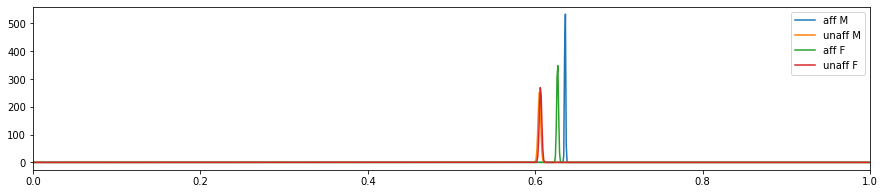

In [131]:
plt.figure(figsize=(15, 3))

#plt.subplot(1, 3, 1)
#plt.plot(np.arange(0, 1.001, 0.001), overall_posteriors_aff[0, :])
#plt.plot(np.arange(0, 1.001, 0.001), overall_posteriors_unaff[0, :])
#plt.xlim([0.45, 0.55])

#plt.subplot(1, 3, 2)
plt.plot(np.arange(0, 1.001, 0.001), overall_posteriors_aff_m[0, :], label='aff M')
plt.plot(np.arange(0, 1.001, 0.001), overall_posteriors_unaff_m[0, :], label='unaff M')
#plt.xlim([0.45, 0.55])

#plt.subplot(1, 3, 3)
plt.plot(np.arange(0, 1.001, 0.001), overall_posteriors_aff_f[0, :], label='aff F')
plt.plot(np.arange(0, 1.001, 0.001), overall_posteriors_unaff_f[0, :], label='unaff F')

plt.xlim([0, 1])
plt.legend()
plt.show()

In [132]:
p = 0.5
prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']

is_double = np.array([del_to_key(d) in double_deletions for d in all_deletions])

family_to_size = dict([(d['family'], d['family_size']) for d in all_deletions])
size_to_dist = defaultdict(list)

for family, size in family_to_size.items():    
    family_transmission = np.zeros((len(all_deletions), 4, 2), dtype=int)
    for i, d in enumerate(all_deletions):
        if (d['family'] == family) and not is_double[i]:
            family_transmission[i, 0, 0] = len([x for x in d['notrans'] if child_id_to_sex[x] == '1' and child_id_to_affected[x] == '2'])
            family_transmission[i, 0, 1] = len([x for x in d['trans'] if child_id_to_sex[x] == '1' and child_id_to_affected[x] == '2'])

            family_transmission[i, 1, 0] = len([x for x in d['notrans'] if child_id_to_sex[x] == '2' and child_id_to_affected[x] == '2'])
            family_transmission[i, 1, 1] = len([x for x in d['trans'] if child_id_to_sex[x] == '2' and child_id_to_affected[x] == '2'])

            family_transmission[i, 2, 0] = len([x for x in d['notrans'] if child_id_to_sex[x] == '1' and child_id_to_affected[x] == '1'])
            family_transmission[i, 2, 1] = len([x for x in d['trans'] if child_id_to_sex[x] == '1' and child_id_to_affected[x] == '1'])

            family_transmission[i, 3, 0] = len([x for x in d['notrans'] if child_id_to_sex[x] == '2' and child_id_to_affected[x] == '1'])
            family_transmission[i, 3, 1] = len([x for x in d['trans'] if child_id_to_sex[x] == '2' and child_id_to_affected[x] == '1'])

    indices = np.sum(family_transmission, axis=(1, 2)) > 0
    if np.sum(indices) > 0:
        vs, cs = np.unique(np.sum(family_transmission[indices, :, :], axis=1), axis=0, return_counts=True)
        v_to_c = dict(list(zip(vs[:, 1], cs)))
        size_to_dist[size].append([0 if v not in v_to_c else v_to_c[v] for v in np.arange(1, size-1)])
        #if size > 3 and np.any(np.array(size_to_dist[size][-1]) > 300):
        #    print(family, size_to_dist[size][-1])


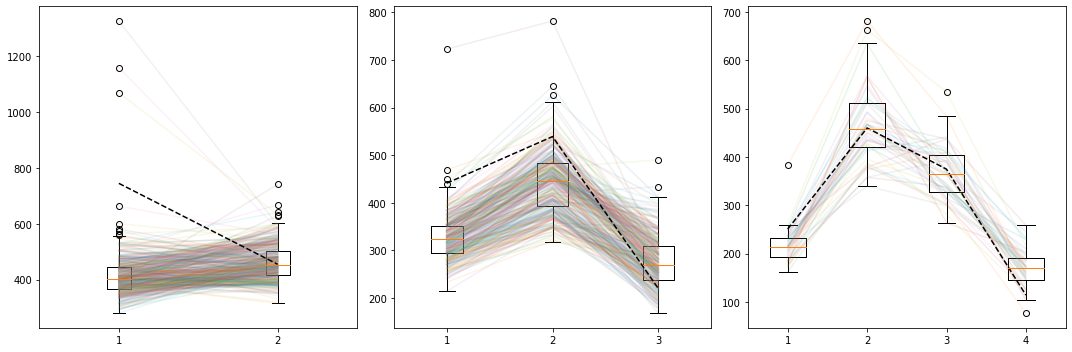

In [160]:
plt.figure(figsize=(15, 5))

p = 0.55
for j in [4, 5, 6]:
    plt.subplot(1, 3, j-3)
    plt.boxplot(np.array(size_to_dist[j]))
    plt.plot(range(1, j-1), np.array(size_to_dist[j]).T, alpha=0.1)
    
    pmf = stats.binom.pmf(np.arange(j-1), j-2, p)
    plt.plot(np.arange(1, j-1), 1200*pmf[1:]/(1-pmf[0]), color='black', linestyle='--')
    
plt.tight_layout()
plt.show()

In [161]:


# deletion, AM/AF/UM/UF, notrans/trans
family_transmission = np.zeros((len(all_deletions), 4, 2), dtype=int)
for i, d in enumerate(all_deletions):
    #print(d['family_size'], 2+len(d['trans'])+len(d['notrans']))
    if (d['family_size'] > 3) and del_to_key(d) not in double_deletions:
        family_transmission[i, 0, 0] = len([x for x in d['notrans'] if child_id_to_sex[x] == '1' and child_id_to_affected[x] == '2'])
        family_transmission[i, 0, 1] = len([x for x in d['trans'] if child_id_to_sex[x] == '1' and child_id_to_affected[x] == '2'])

        family_transmission[i, 1, 0] = len([x for x in d['notrans'] if child_id_to_sex[x] == '2' and child_id_to_affected[x] == '2'])
        family_transmission[i, 1, 1] = len([x for x in d['trans'] if child_id_to_sex[x] == '2' and child_id_to_affected[x] == '2'])

        family_transmission[i, 2, 0] = len([x for x in d['notrans'] if child_id_to_sex[x] == '1' and child_id_to_affected[x] == '1'])
        family_transmission[i, 2, 1] = len([x for x in d['trans'] if child_id_to_sex[x] == '1' and child_id_to_affected[x] == '1'])

        family_transmission[i, 3, 0] = len([x for x in d['notrans'] if child_id_to_sex[x] == '2' and child_id_to_affected[x] == '1'])
        family_transmission[i, 3, 1] = len([x for x in d['trans'] if child_id_to_sex[x] == '2' and child_id_to_affected[x] == '1'])


print(np.sum(np.any(family_transmission > 0, axis=(1, 2))))



728051


In [162]:
# combine family_transmission

vs, cs = np.unique(family_transmission, axis=0, return_counts=True)

print(vs.shape, cs.shape)

(223, 4, 2) (223,)


In [165]:
grid = np.arange(0.001, 1, 0.001)

def estimate_transmission(vs, counts, max_iters=1, l1_convergence_cutoff=np.power(10.0, -2)):
    prior = stats.beta.pdf(grid, 2, 2)

    prev_ps = None
    ps = np.array([0.5 for _ in range(vs.shape[1])])
    diff = 1
    num_iters = 0
    
    while diff>l1_convergence_cutoff and num_iters<max_iters:
        posteriors = np.array([np.log(prior) for _ in range(vs.shape[1])]).T
        
        # for each transmission probability
        for index in range(vs.shape[1]):

            for i in range(vs.shape[0]):
                ns = np.sum(vs[i, :, :], axis=1)

                p_nt = np.ones(grid.shape)
                for j, (p, n) in enumerate(zip(ps, ns)):
                    if j==index:
                        p_nt = p_nt * np.power(1-grid, n)
                    else:
                        p_nt = p_nt * np.power(1-p, n)

                for j in np.where(ns > 0)[0]:
                    if j==index:
                        qs = grid
                    else:
                        qs = ps[j]

                    posteriors[:, index] += counts[i] * ((vs[i, j, 1] * np.log(qs)) + (vs[i, j, 0] * np.log(1-qs)) - np.log(1-p_nt))

            # switch back to probability space
            posteriors[:, index] = np.exp(posteriors[:, index] - np.max(posteriors[:, index]))
            posteriors[:, index] = posteriors[:, index]/np.sum(posteriors[:, index])
         
        # check convergence
        ps = np.array([np.mean(grid.shape[0]*grid*posteriors[:, i]) for i in range(vs.shape[1])])
        diff = 1 if prev_ps is None else np.sum(np.abs(ps-prev_ps))
        prev_ps = ps
        num_iters += 1

    #if diff>l1_convergence_cutoff:
    #	print('did not converge')
    #	#posteriors[:] = np.nan
    #	#ps = [np.nan, np.nan, np.nan, np.nan]

    return posteriors, ps, diff

posteriors, ps, diff = estimate_transmission(vs, cs)

[0.54983622 0.47254016 0.48452305 0.48450108] 1


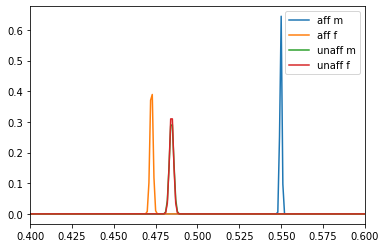

In [166]:
print(ps, diff)
for i in range(4):
    plt.plot(grid, posteriors[:, i], label=labels[i])
plt.xlim([0.4, 0.6])
plt.legend()
plt.show()

[0.55244666 0.50282322 0.51072237 0.51045974] 0.005210805627507975


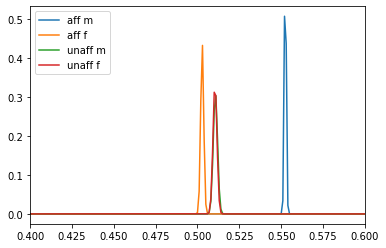

In [164]:
print(ps, diff)
for i in range(4):
    plt.plot(grid, posteriors[:, i], label=labels[i])
plt.xlim([0.4, 0.6])
plt.legend()
plt.show()

[0.50280265 0.48320082 0.48892189 0.48528377] 0.002746541777474132


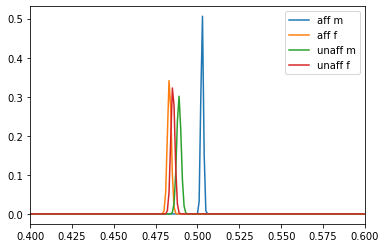

In [151]:
print(ps, diff)
for i in range(4):
    plt.plot(grid, posteriors[:, i], label=labels[i])
plt.xlim([0.4, 0.6])
plt.legend()
plt.show()

In [ ]:
print(ps, diff)
for i in range(4):
    plt.plot(grid, posteriors[:, i], label=labels[i])
plt.xlim([0.4, 0.7])
plt.legend()
plt.show()

In [41]:
p = 0.7

for i in range(4):
    print(p/(1-(1-p)**(i+1)), overall_contingency_aff[i, 1]/np.sum(overall_contingency_aff[i, :]), overall_contingency_unaff[i, 1]/np.sum(overall_contingency_unaff[i, :]))

print('M')
for i in range(4):
    print(p/(1-(1-p)**(i+1)), overall_contingency_aff_m[i, 1]/np.sum(overall_contingency_aff_m[i, :]), overall_contingency_unaff_m[i, 1]/np.sum(overall_contingency_unaff_m[i, :]))
    
print('F')
for i in range(4):
    print(p/(1-(1-p)**(i+1)), overall_contingency_aff_f[i, 1]/np.sum(overall_contingency_aff_f[i, :]), overall_contingency_unaff_f[i, 1]/np.sum(overall_contingency_unaff_f[i, :]))


1.0 1.0 1.0
0.7692307692307693 0.7581277782620065 0.7107969151670951
0.7194244604316546 0.6482998041659249 0.6485823002332147
0.7057163020465772 0.5990396158463386 0.5991440798858774
M
1.0 1.0 nan
0.7692307692307693 0.760148849797023 0.683291770573566
0.7194244604316546 0.6503879507074395 0.6637458926615553
0.7057163020465772 0.6079295154185022 0.6070763500931099
F
1.0 1.0 1.0
0.7692307692307693 0.7512476007677543 0.7400530503978779
0.7194244604316546 0.6408906882591093 0.6362625139043382
0.7057163020465772 0.5883905013192612 0.5908649173955296


//anaconda3/lib/python3.7/site-packages/ipykernel/__main__.py:8: RuntimeWarning: invalid value encountered in long_scalars


In [ ]:
interval_contingency_aff = np.zeros((len(intervals), 5, 2), dtype=int)
interval_contingency_unaff = np.zeros((len(intervals), 5, 2), dtype=int)

interval_contingency_aff_m = np.zeros((len(intervals), 5, 2), dtype=int)
interval_contingency_unaff_m = np.zeros((len(intervals), 5, 2), dtype=int)

interval_contingency_aff_f = np.zeros((len(intervals), 5, 2), dtype=int)
interval_contingency_unaff_f = np.zeros((len(intervals), 5, 2), dtype=int)

interval_contingency_aff_mat = np.zeros((len(intervals), 5, 2), dtype=int)
interval_contingency_unaff_mat = np.zeros((len(intervals), 5, 2), dtype=int)

interval_contingency_aff_pat = np.zeros((len(intervals), 5, 2), dtype=int)
interval_contingency_unaff_pat = np.zeros((len(intervals), 5, 2), dtype=int)

for chrom in chroms:
    print(chrom, end=' ')
    with open('%s/chr.%s.deletions.json' % (deletion_dir, chrom), 'r') as f:
        deletions = json.load(f)
    families = set([d['family'] for d in deletions])

    deletions = set()
    with open('%s/chr.%s.collections.json' % (deletion_dir, chrom), 'r') as f:
        collections = json.load(f)
    for c in collections:
        if len(c['matches']) <= af_cutoff*len(families)*4:
            for d in c['matches']:
                d['trans'] = tuple(sorted(d['trans']))
                d['notrans'] = tuple(sorted(d['notrans']))
                deletions.add(Deletion(**d))
    print('deletions', len(deletions))
    
    contingency = np.load('%s/chr.%s.contingency.npz' % (deletion_dir, chrom))
    contingency_aff = contingency['aff'].astype(int)
    contingency_unaff = contingency['unaff'].astype(int)

    for d in deletions:
        if d.length >= length_cutoff:
            start_pos, end_pos = d.start_pos, d.end_pos
            for interval_index, (ch, cyto, chrom_start_pos, chrom_end_pos) in enumerate(intervals):
                if (chrom == ch) and (((start_pos >= chrom_start_pos) and (start_pos <= chrom_end_pos)) or ((end_pos >= chrom_start_pos) & (end_pos <= chrom_end_pos))):
                    interval_contingency_aff[interval_index, familysize_to_index[d.family_size], 0] += len([x for x in d.notrans if child_id_to_affected[x] == '2'])
                    interval_contingency_aff[interval_index, familysize_to_index[d.family_size], 1] += len([x for x in d.trans if child_id_to_affected[x] == '2'])
                    interval_contingency_unaff[interval_index, familysize_to_index[d.family_size], 0] += len([x for x in d.notrans if child_id_to_affected[x] == '1'])
                    interval_contingency_unaff[interval_index, familysize_to_index[d.family_size], 1] += len([x for x in d.trans if child_id_to_affected[x] == '1'])

                    interval_contingency_aff_m[interval_index, familysize_to_index[d.family_size], 0] += len([x for x in d.notrans if child_id_to_affected[x] == '2' and child_id_to_sex[x] == '1'])
                    interval_contingency_aff_m[interval_index, familysize_to_index[d.family_size], 1] += len([x for x in d.trans if child_id_to_affected[x] == '2' and child_id_to_sex[x] == '1'])
                    interval_contingency_unaff_m[interval_index, familysize_to_index[d.family_size], 0] += len([x for x in d.notrans if child_id_to_affected[x] == '1' and child_id_to_sex[x] == '1'])
                    interval_contingency_unaff_m[interval_index, familysize_to_index[d.family_size], 1] += len([x for x in d.trans if child_id_to_affected[x] == '1' and child_id_to_sex[x] == '1'])

                    interval_contingency_aff_f[interval_index, familysize_to_index[d.family_size], 0] += len([x for x in d.notrans if child_id_to_affected[x] == '2' and child_id_to_sex[x] == '2'])
                    interval_contingency_aff_f[interval_index, familysize_to_index[d.family_size], 1] += len([x for x in d.trans if child_id_to_affected[x] == '2' and child_id_to_sex[x] == '2'])
                    interval_contingency_unaff_f[interval_index, familysize_to_index[d.family_size], 0] += len([x for x in d.notrans if child_id_to_affected[x] == '1' and child_id_to_sex[x] == '2'])
                    interval_contingency_unaff_f[interval_index, familysize_to_index[d.family_size], 1] += len([x for x in d.trans if child_id_to_affected[x] == '1' and child_id_to_sex[x] == '2'])
                    
                    interval_contingency_aff_mat[interval_index, familysize_to_index[d.family_size], 0] += len([x for x in d.notrans if child_id_to_affected[x] == '2' and d.is_mat])
                    interval_contingency_aff_mat[interval_index, familysize_to_index[d.family_size], 1] += len([x for x in d.trans if child_id_to_affected[x] == '2' and d.is_mat])
                    interval_contingency_unaff_mat[interval_index, familysize_to_index[d.family_size], 0] += len([x for x in d.notrans if child_id_to_affected[x] == '1' and d.is_mat])
                    interval_contingency_unaff_mat[interval_index, familysize_to_index[d.family_size], 1] += len([x for x in d.trans if child_id_to_affected[x] == '1' and d.is_mat])

                    interval_contingency_aff_pat[interval_index, familysize_to_index[d.family_size], 0] += len([x for x in d.notrans if child_id_to_affected[x] == '2' and not d.is_mat])
                    interval_contingency_aff_pat[interval_index, familysize_to_index[d.family_size], 1] += len([x for x in d.trans if child_id_to_affected[x] == '2' and not d.is_mat])
                    interval_contingency_unaff_pat[interval_index, familysize_to_index[d.family_size], 0] += len([x for x in d.notrans if child_id_to_affected[x] == '1' and not d.is_mat])
                    interval_contingency_unaff_pat[interval_index, familysize_to_index[d.family_size], 1] += len([x for x in d.trans if child_id_to_affected[x] == '1' and not d.is_mat])


In [ ]:
transrates_aff = btr.calculate_transmission_rates(interval_contingency_aff, family_sizes, na_cutoff=0)
transrates_unaff = btr.calculate_transmission_rates(interval_contingency_unaff, family_sizes, na_cutoff=0)

transrates_aff_m = btr.calculate_transmission_rates(interval_contingency_aff_m, family_sizes, na_cutoff=0)
transrates_unaff_m = btr.calculate_transmission_rates(interval_contingency_unaff_m, family_sizes, na_cutoff=0)

transrates_aff_f = btr.calculate_transmission_rates(interval_contingency_aff_f, family_sizes, na_cutoff=0)
transrates_unaff_f = btr.calculate_transmission_rates(interval_contingency_unaff_f, family_sizes, na_cutoff=0)

transrates_aff_mat = btr.calculate_transmission_rates(interval_contingency_aff_mat, family_sizes, na_cutoff=0)
transrates_unaff_mat = btr.calculate_transmission_rates(interval_contingency_unaff_mat, family_sizes, na_cutoff=0)

transrates_aff_pat = btr.calculate_transmission_rates(interval_contingency_aff_pat, family_sizes, na_cutoff=0)
transrates_unaff_pat = btr.calculate_transmission_rates(interval_contingency_unaff_pat, family_sizes, na_cutoff=0)

In [ ]:
posteriors_aff = btr.calculate_posteriors(interval_contingency_aff, family_sizes)
posteriors_unaff = btr.calculate_posteriors(interval_contingency_unaff, family_sizes)

posteriors_aff_m = btr.calculate_posteriors(interval_contingency_aff_m, family_sizes)
posteriors_unaff_m = btr.calculate_posteriors(interval_contingency_unaff_m, family_sizes)

posteriors_aff_f = btr.calculate_posteriors(interval_contingency_aff_f, family_sizes)
posteriors_unaff_f = btr.calculate_posteriors(interval_contingency_unaff_f, family_sizes)

posteriors_aff_mat = btr.calculate_posteriors(interval_contingency_aff_mat, family_sizes)
posteriors_unaff_mat = btr.calculate_posteriors(interval_contingency_unaff_mat, family_sizes)

posteriors_aff_pat = btr.calculate_posteriors(interval_contingency_aff_pat, family_sizes)
posteriors_unaff_pat = btr.calculate_posteriors(interval_contingency_unaff_pat, family_sizes)

In [ ]:
overlap = btr.calculate_posterior_overlap(posteriors_aff, posteriors_unaff)
overlap_m = btr.calculate_posterior_overlap(posteriors_aff_m, posteriors_unaff_m)
overlap_f = btr.calculate_posterior_overlap(posteriors_aff_f, posteriors_unaff_f)
overlap_mat = btr.calculate_posterior_overlap(posteriors_aff_mat, posteriors_unaff_mat)
overlap_pat = btr.calculate_posterior_overlap(posteriors_aff_pat, posteriors_unaff_pat)

posterior_pvalues_aff = btr.calculate_posterior_pvalue(posteriors_aff)
posterior_pvalues_unaff = btr.calculate_posterior_pvalue(posteriors_unaff)

In [ ]:
cutoff = 0.05/(np.sum(transrates_aff > transrates_unaff) + np.sum(transrates_aff < transrates_unaff))

plt.figure(figsize=(15, 5))
plt.plot(np.where(transrates_aff > transrates_unaff)[0], -np.log10(overlap[transrates_aff > transrates_unaff]), alpha=0.5, label='aff greater')
plt.plot(np.where(transrates_aff < transrates_unaff)[0], -np.log10(overlap[transrates_aff < transrates_unaff]), alpha=0.5, label='unaff greater')

plt.plot(np.where(transrates_aff > transrates_unaff)[0], -np.log10(overlap_m[transrates_aff > transrates_unaff]), alpha=0.5, label='M aff greater')
plt.plot(np.where(transrates_aff < transrates_unaff)[0], -np.log10(overlap_m[transrates_aff < transrates_unaff]), alpha=0.5, label='M unaff greater')

plt.plot(np.where(transrates_aff > transrates_unaff)[0], -np.log10(overlap_f[transrates_aff > transrates_unaff]), alpha=0.5, label='F aff greater')
plt.plot(np.where(transrates_aff < transrates_unaff)[0], -np.log10(overlap_f[transrates_aff < transrates_unaff]), alpha=0.5, label='F unaff greater')

plt.plot(np.where(transrates_aff > transrates_unaff)[0], -np.log10(overlap_mat[transrates_aff > transrates_unaff]), alpha=0.5, label='mat aff greater')
plt.plot(np.where(transrates_aff < transrates_unaff)[0], -np.log10(overlap_mat[transrates_aff < transrates_unaff]), alpha=0.5, label='mat unaff greater')

plt.plot(np.where(transrates_aff > transrates_unaff)[0], -np.log10(overlap_pat[transrates_aff > transrates_unaff]), alpha=0.5, label='pat aff greater')
plt.plot(np.where(transrates_aff < transrates_unaff)[0], -np.log10(overlap_pat[transrates_aff < transrates_unaff]), alpha=0.5, label='pat unaff greater')


#plt.plot(-np.log10(posterior_pvalues_aff[:, 0]), alpha=0.5, label='aff higher')
#plt.plot(-np.log10(posterior_pvalues_unaff[:, 0]), alpha=0.5, label='unaff_higher')
#plt.plot(-np.log10(posterior_pvalues_unaff[:, 1]), alpha=0.5, label='aff_lower')
#plt.plot(-np.log10(posterior_pvalues_unaff[:, 1]), alpha=0.5, label='unaff_lower')

plt.xticks(first_chrom, chroms, rotation=90)
plt.axhline(-np.log10(cutoff), color='black', linestyle='--')
plt.legend()
plt.show()

In [ ]:
plt.figure(figsize=(15, 3))

plt.subplot(1, 2, 1)
plt.hist(np.log10(overlap)[transrates_aff > transrates_unaff], log=True, bins=np.arange(-11, 0.1, 0.1))
plt.plot(np.arange(0, -3, -0.1), np.sum(transrates_aff > transrates_unaff)*np.power(10, np.arange(0, -3, -0.1)))

plt.subplot(1, 2, 2)
plt.hist(np.log10(overlap)[transrates_aff < transrates_unaff], log=True, bins=np.arange(-11, 0.1, 0.1))
plt.plot(np.arange(-3, 0.1, 0.1), np.sum(transrates_aff < transrates_unaff)*np.power(10, np.arange(-3, 0.1, 0.1)))
plt.show()

In [ ]:
print('affected greater')
for i in np.where((transrates_aff > transrates_unaff) & (-np.log10(overlap) > -np.log10(cutoff)))[0]:
    print(intervals[i][0] + intervals[i][1], -np.log10(overlap)[i], transrates_aff[i], transrates_unaff[i], sep='\t')
                                     
print('unaffected greater')
for i in np.where((transrates_aff < transrates_unaff) & (-np.log10(overlap) > -np.log10(cutoff)))[0]:
    print(intervals[i][0] + intervals[i][1], -np.log10(overlap)[i], transrates_aff[i], transrates_unaff[i], sep='\t')

print('affected higher')
for i in np.where((transrates_aff < transrates_unaff) & (-np.log10(posterior_pvalues_aff[:, 0]) > -np.log10(cutoff)))[0]:
    print(intervals[i][0] + intervals[i][1], -np.log10(overlap)[i], transrates_aff[i], transrates_unaff[i], sep='\t')
      

In [ ]:
print('affected greater')
for i in np.where((transrates_aff > transrates_unaff) & (-np.log10(overlap) > -np.log10(0.05/len(intervals))))[0]:
    print(intervals[i][0] + intervals[i][1], -np.log10(overlap)[i], transrates_aff[i], transrates_unaff[i], sep='\t')
                                     
print('unaffected greater')
for i in np.where((transrates_aff < transrates_unaff) & (-np.log10(overlap) > -np.log10(0.05/len(intervals))))[0]:
    print(intervals[i][0] + intervals[i][1], -np.log10(overlap)[i], transrates_aff[i], transrates_unaff[i], sep='\t')
                                        